# Project: an interpretable VAE to study Transcription Factor rewiring

## Introduction

Contact: Carl Herrmann, Daria Doncevic (Heidelberg University carl.herrmann@bioquant.uni-heidelberg.de daria.doncevic@bioquant.uni-heidelberg.de)

Variational Autoencoders are now widely applied to capture the complexity in single-cell omics datasets and can be used to replace complete workflows of data analysis consisting of normalization, clustering, celltype annotation and differential expression analysis. However, due to their non-linear nature, they lack interpretability. As you have learned in week 2 of the course, a subset of VAE models such as the VEGA model ([Seninge *et al* (2021)](https://www.nature.com/articles/s41467-021-26017-0)) can convey intrinsic interpretability by incorporating biological networks directly into their model structure. In VEGA, every node in the latent space corresponds to a biological entity such as a pathway or transcription factor (TF) and is then connected only to the genes in the reconstruction layer that are annotated to that biological entity, making the one-layered decoder sparse. Thus, the activations of the nodes in the latent space can be interpreted as pathway or TF activities. In this project, you are going to focus more on the weights of the decoder connections than on the latent space activities, and see how they differ for different genes for a given TF. We believe that this change in the weights between TF and target genes might indicate a rewiring of the TF in different biological condition.
You are also going to estimate uncertainties for the weights (which also depends on the annotation that is used) and to investigate how the weights change in condition versus control, which we call "Transcription factor rewiring".

## Goal
The goal of this project is to study Transcription factor rewiring in the context of interferon response. Thus, you should focus especially on TFs that are known to play a role in interferon response, such as STAT1, STAT2, and the different IRFs, and their target genes. You can read more about that [in this review](https://www.nature.com/articles/nri3787). To be able to obtain different weights for condition and control, you will have to train two separate models. Since VAEs are probabilistic, you will end up with a different set of weights each time you train the model. Thus, your task will also be to estimate or compute uncertainties for the weights. There are different ways to achieve this:


*   Train each model multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others?
*   When we train multiple models and then aggregate their results, we also call this an ensemble. Training an ensemble is often expensive in terms of computational time and power. Stochastic Weight Averaging (SWA) has been proposed as a method that can yield more robust weights without the need of training ensembles. The publication is linked [here](https://arxiv.org/pdf/1803.05407), and additional information can be found [here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/). Try to implement this approach for your VEGA model.
*   Bayesian Neural Networks do built-in estimation of weight uncertainties. Try to replace your linear layer with a Bayesian layer to obtain these estimates. You can find some information to get you started [in this blogpost](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825/). More mathematical foundations can also be found [here](https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/).

Do not forget to also include some biological speculation/interpretation of your results!

Questions

1) Which data we should choose for selecting weights -> processed data or raw regulon data -> if raw regulon data which column we should choose such as stimulation or inhibition colummn

2) In the mask, does 1 mean TF is regulating the gene and 0 means there is no regulation? What happens if we put -1 in the mask, as a way of incorporating inhibition regulation?

3) How to organize the final result? presentation? poster?

## Data and model

As in week 2, you will use a dataset that contains peripheral blood mononuclear cells (PBMCs) from systemic lupus patients, treated with Interferon beta or untreated (control). You can follow the steps from week 2's notebook to download the data. You will also work with a VEGA-like model, and you can reuse code from week 2 for the implementation.

This time, instead of Reactome pathways, you will use TF regulons from the collecTRI database as a biological prior. Information about this resource and how to obtain the data is available [here](https://github.com/saezlab/CollecTRI). You might want to filter the regulons based on regulon size prior to incorporation into the model.

# Load packages and dataset

In [1]:
#!pip install scanpy
#!pip install omnipath
#!pip install decoupler
#!pip install torchbnn

import torch
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from collections import OrderedDict, defaultdict
from collections import Counter

import decoupler as dc
import omnipath as op

device = 'mps'

/opt/anaconda3/envs/vae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# download PBMC dataset for training
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad
# load data as anndata object
PBMC_train = sc.read_h5ad("PBMC_train.h5ad")

# for validation
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj' -O PBMC_valid.h5ad
# load data as anndata object
PBMC_valid = sc.read_h5ad( "PBMC_valid.h5ad")

In [3]:
# download raw regulons from OmniPath
raw_regulons = op.interactions.CollecTRI.get(genesymbols=True, organism="human", loops=True)
print(raw_regulons.columns)

Index(['source', 'target', 'source_genesymbol', 'target_genesymbol',
       'is_directed', 'is_stimulation', 'is_inhibition', 'consensus_direction',
       'consensus_stimulation', 'consensus_inhibition', 'curation_effort',
       'references', 'sources', 'n_sources', 'n_primary_sources',
       'n_references', 'references_stripped'],
      dtype='object')


In [4]:
raw_regulons    # source: TF, target: gene is stimulated or inhibited by the TF

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P01106,O14746,MYC,TERT,False,True,False,True,True,False,82,CollecTRI:10022128;CollecTRI:10491298;CollecTR...,CollecTRI;DoRothEA-A_CollecTRI;ExTRI_CollecTRI...,8,1,74,10022128;10491298;10606235;10637317;10723141;1...
1,P17947,P02818,SPI1,BGLAP,False,True,False,True,True,False,3,CollecTRI:10022617,CollecTRI;ExTRI_CollecTRI,2,1,1,10022617
2,COMPLEX:P15407_P17275,P05412,FOSL1_JUNB,JUN,False,True,False,True,True,False,53,CollecTRI:10022869;CollecTRI:10037172;CollecTR...,CollecTRI;ExTRI_CollecTRI;NTNU.Curated_CollecT...,4,1,49,10022869;10037172;10208431;10366004;11281649;1...
3,COMPLEX:P01100_P05412,P05412,FOS_JUN,JUN,False,True,False,True,True,False,53,CollecTRI:10022869;CollecTRI:10037172;CollecTR...,CollecTRI;ExTRI_CollecTRI;NTNU.Curated_CollecT...,4,1,49,10022869;10037172;10208431;10366004;11281649;1...
4,COMPLEX:P01100_P17275,P05412,FOS_JUNB,JUN,False,True,False,True,True,False,53,CollecTRI:10022869;CollecTRI:10037172;CollecTR...,CollecTRI;ExTRI_CollecTRI;NTNU.Curated_CollecT...,4,1,49,10022869;10037172;10208431;10366004;11281649;1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64953,Q01196,Q13094,RUNX1,LCP2,False,True,False,True,True,False,3,CollecTRI:20019798,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,20019798
64954,Q01196,Q6MZQ0,RUNX1,PRR5L,False,True,False,True,True,False,3,CollecTRI:20019798,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,20019798
64955,Q15672,P08151,TWIST1,GLI1,False,True,False,True,True,False,3,CollecTRI:11948912,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,11948912
64956,P22415,Q5SRE5,USF1,NUP188,False,True,False,True,True,False,3,CollecTRI:22951020,CollecTRI;DoRothEA-A_CollecTRI,2,1,1,22951020


In [5]:
# compute size of regulons = number of unique target genes regulated by a TF
regulon_sizes = raw_regulons.groupby("source_genesymbol")["target_genesymbol"].nunique()
raw_regulons["size"] = raw_regulons["source_genesymbol"].map(regulon_sizes)

### TODO: NEED TO SET THRESHOLD FOR REGULON SIZE AND FILTER!!!!!!!

- median size?
- good to restrict the lower bound of regulon size because, essentially we are looking at how much genes are enriched in that TF or pathway. And, if we want a reliable proportion of weights to estimate how much each gene contribute in the pathway, we want enough number of genes regulated by that TF/pathway. So, filter out regulons smaller than 5.
- for the upper bound, unless the TF regulates like more than half of the genes in the dataset, it is fine to include them.


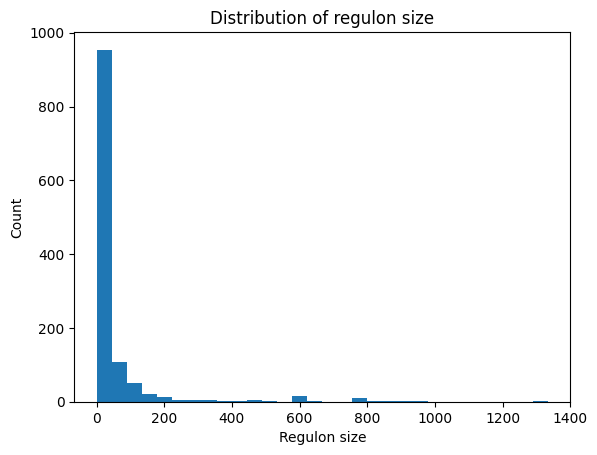

In [6]:
# Distribution of regulon size -> Median?
plt.hist(regulon_sizes, bins=30)
plt.xlabel("Regulon size")
plt.ylabel("Count")
plt.title("Distribution of regulon size")
plt.show()

selected_tfs = regulon_sizes[(regulon_sizes > 10) & (regulon_sizes < 1100)].index.tolist()

## Creating gmt files
Consider only stimulation or also train it for inhibition as well?
But this really depends because the direction of regulation depends on the tissues.

In [7]:
# download processed regulons and filter by selected_tfs
processed_regulons = dc.get_collectri(organism="human", split_complexes=False)
filtered_regulons = processed_regulons[processed_regulons["source"].isin(selected_tfs)]

In [9]:
# Activator TFs
activator_dict = defaultdict(list)
for _, row in filtered_regulons.iterrows():
    if row["weight"] == 1:            # weight = 1 means TF is an activator
        activator_dict[row["source"]].append(row["target"])

# Write to GMT
with open("activator.gmt", "w") as f:
    for tf, targets in activator_dict.items():
        line = [tf, ""] + list(set(targets))  # remove duplicates
        f.write("\t".join(line) + "\n")


In [10]:
# Inhibitor TFs
inhibitor_dict = defaultdict(list)
for _, row in filtered_regulons.iterrows():
    if row["weight"] == -1:            # weight = 1 means TF is an inhibitor
        inhibitor_dict[row["source"]].append(row["target"])

# Write to GMT
with open("inhibitor.gmt", "w") as f:
    for tf, targets in inhibitor_dict.items():
        line = [tf, ""] + list(set(targets))  # remove duplicates
        f.write("\t".join(line) + "\n")

In [11]:
# Find TFs that regulate IFNA or IFNB
regulon_genes = filtered_regulons["target"].unique()
STAT_genes = [g for g in regulon_genes if g.startswith("IF") or g.startswith("ISG") or g.startswith("TRIM")]
STAT_genes += ["STAT1", "STAT2", "MX1", "EIF2AK2"]
print(f"{len(STAT_genes)} genes related to STAT1, STAT2, interferons in our pathway info: ")
print(STAT_genes, "\n")

# Add TFs that regulate STAT1 and STAT2
STAT_tfs = filtered_regulons[filtered_regulons["target"].isin(STAT_genes)]["source"].unique()
print(f"{len(STAT_tfs)} TFs regulate those genes: ")
print(STAT_tfs.tolist(), "\n")
STAT_regulons = filtered_regulons[filtered_regulons["source"].isin(STAT_tfs)]
print("Number of instances where these TFs activate a gene: ", len(STAT_regulons[STAT_regulons["weight"] == 1]))
print("Number of instances where these TFs inhibits a gene: ",len(STAT_regulons[STAT_regulons["weight"] == -1]))

# STAT related activators
STAT_activator_dict = defaultdict(list)
for _, row in STAT_regulons.iterrows():
    if row["weight"] == 1:            # weight = 1 means TF is an activator
        STAT_activator_dict[row["source"]].append(row["target"])

# Write to GMT
with open("STAT_activator.gmt", "w") as f:
    for tf, targets in STAT_activator_dict.items():
        line = [tf, ""] + list(set(targets))  # remove duplicates
        f.write("\t".join(line) + "\n")

# STAT related inhibitors
STAT_inhibitor_dict = defaultdict(list)
for _, row in STAT_regulons.iterrows():
    if row["weight"] == 1:            # weight = 1 means TF is an activator
        STAT_inhibitor_dict[row["source"]].append(row["target"])

# Write to GMT
with open("STAT_inhibitor.gmt", "w") as f:
    for tf, targets in STAT_inhibitor_dict.items():
        line = [tf, ""] + list(set(targets))  # remove duplicates
        f.write("\t".join(line) + "\n")

61 genes related to STAT1, STAT2, interferons in our pathway info: 
['IFNA1', 'IFNG', 'IFNL3', 'IFNB1', 'TRIM63', 'IFI27', 'IFIT1', 'IFNA5', 'IFNA4', 'ISG15', 'IFIT2', 'IFNA16', 'IFI16', 'ISG20', 'TRIM28', 'IFT88', 'IFNL1', 'IFITM3', 'IFITM2', 'IFNGR1', 'TRIM68', 'IFNA17', 'TRIM10', 'TRIM11', 'IFIT3', 'IFNAR1', 'TRIM72', 'IFNLR1', 'TRIM35', 'TRIM3', 'TRIM17', 'TRIM22', 'TRIM16', 'IFI30', 'TRIM5', 'TRIM8', 'IFI35', 'IFT20', 'IFRD1', 'IFITM5', 'TRIM32', 'TRIM21', 'TRIM62', 'IFNE', 'TRIM25', 'IFRD2', 'IFNA2', 'IFNL2', 'IFITM1', 'IFI6', 'IFNA14', 'IFNA6', 'IFNA7', 'IFNA10', 'IFNA8', 'IFNA21', 'TRIM33', 'STAT1', 'STAT2', 'MX1', 'EIF2AK2'] 

173 TFs regulate those genes: 
['STAT4', 'IRF3', 'IRF1', 'RELA', 'TP53', 'IRF8', 'ETV5', 'IRF2', 'STAT1', 'STAT6', 'IRF9', 'CIITA', 'TBX21', 'ATF2', 'JUN', 'CUX1', 'NFATC2', 'IRF7', 'CEBPB', 'SPI1', 'IRF5', 'CEBPG', 'CREB1', 'FOS', 'GATA3', 'MAF', 'NFKB1', 'PITX1', 'YBX1', 'NR1I2', 'YY1', 'PPARA', 'TFAP4', 'NCOA1', 'SP3', 'STAT2', 'HMGA1', 'IRF4', 'ZNF14

# VEGA Architecture

**VEGA model**
- a variational autoencoder model enhanced by gene annotations
- users can provide prior knowledge of gene to the *decoder* e.g. gene regulatory network
- allowing the latent variables to be directly interpretable

**Encoder**
- Two fully connected layer with dropout
- Since we are building a variational autoencoder which aims to learn a *probabilistic* latent space, we use a reparameterization trick.
 - Reparameterization trick is needed because backpropagation is computationally challenging when the latent space is probabilistic
 - So, we decompose the latent variable into $ z = \mu+\epsilon\cdot\sigma, \text{where } \epsilon \sim N(0,1)$. Then, gradients can be computed as the random variable $\epsilon$, independent of learnable parameters of the network ($\phi$ for encoder, $\theta$ for decoder).

**Decoder**
- to achieve biological interpretability, we must provide a gene module that defines how the nodes in decoder layers are connected
- this definition is fed to the model by creating a *mask*


**Dataset?**
- we use CollecTRI dataset to define transcriptional regulatory interactions (which TF targets which genes)

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)     # epsilon(error)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x)) # exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)  # reparameterization trick
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z

In [9]:
####### In the following sections, we used and adapted code from https://github.com/LucasESBS/vega ######

def create_mask(adata, gmt_path:str=None, add_nodes:int=1, sep = "\t"):
    """
    Initialize mask M for GMVs from a .gmt file
    Args:
        adata (Anndata): Scanpy single-cell object, we will store the computed mask and the names of the biological processes there
        gmt_path (str): path to .gmt file
        add_nodes (int): Additional latent nodes for capturing additional variance
    Return:
        adata (Anndata): Scanpy single-cell object that now stores the computed mask and the names of biological processes (in the .uns["_vega"] attribute)
        mask (array): mask M that specifies whether a gene is regulated (value 1) or not regulated (value 0) by TFs
    """

    regulon_dict = OrderedDict()
    with open(gmt_path) as f:
        for line in f.readlines():
            line = line.strip()
            spli = line.split(sep)
            regulon_dict[spli[0]] = spli[2:]

    feature_list = adata.var.index.tolist()


    # Create mask
    mask = np.zeros((len(feature_list), len(regulon_dict)))
    for j, k in enumerate(regulon_dict.keys()):
        for i in range(mask.shape[0]):
            if feature_list[i] in regulon_dict[k]:
                mask[i,j] = 1.      # 1 means target is regulated (either stimulated or inhibited depending on the gmt file) by TF,
                                    # 0 means target is not regulated by TF

    # Add unannotated nodes
    vec = np.ones((mask.shape[0], add_nodes))
    mask = np.hstack((mask, vec))

    adata = adata.copy()
    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = mask
    adata.uns['_vega']['gmv_names'] = list(regulon_dict.keys()) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]

    return adata, mask

In [ ]:
# define VEGA's decoder

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear, positive)
  """
  def __init__(self,
               mask, ):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

  def positive_weights(self):
      """
      constrain the decoder to positive weights (set negative weigths to zero)
      """
      w = self.sparse_layer[0].weight
      w.data = w.data.clamp(0)
      return w


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))

        self.reset_parameters()

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


######### You don't need to understand this part of the code in detail #########
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):
        weight = weight * (mask != 0) # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, None

In [ ]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Training functions

In [12]:
### training loop
def trainVEGA_with_valid(vae, data, val_data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta* vae.encoder.kl
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()

        for x in val_data:
            x = x.to(device)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))

        if epoch % 10 == 0:
            print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128), "  valid_loss: ", valid_loss_e/(len(val_data)*128))

    return vae, train_losses, valid_losses

In [13]:
def get_weight(vae):
  vae.eval()
  return vae.decoder.sparse_layer[0].weight.data.cpu().numpy()

# TODO: Implement Stochastic Weight Averaging (SWA)

* aggregates predictions of multiple models by SWA e.g.
  (cond1, cond2, ..) and (ctrl1, ctrl2, ..)
* can yield more robust weights
* SWA performs an equal average of the weights traversed by SGD with a modified learning rate schedule

In [59]:
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

def trainVEGA_with_swa(vae, data, val_data, epochs=100, beta=0.0001,
                       learning_rate=0.0005, swa_start=75, swa_lr=0.05):
    opt = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=5e-4)
    swa_model = AveragedModel(vae)           # will hold the running average
    swa_scheduler = SWALR(opt, swa_lr=swa_lr)

    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        vae.train()
        train_loss_e = 0.
        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
            loss.backward()
            opt.step()
            vae.decoder.positive_weights()
            train_loss_e += loss.detach().cpu().item()

        # start updating our SWA weights
        if epoch >= swa_start:
            swa_model.update_parameters(vae)
            swa_scheduler.step()

        train_losses.append(train_loss_e / (len(data) * data.batch_size))

        # validation
        vae.eval()
        valid_loss_e = 0.
        with torch.no_grad():
            for x in val_data:
                x = x.to(device)
                x_hat = vae(x)
                loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
                valid_loss_e += loss.detach().cpu().item()
        valid_losses.append(valid_loss_e / (len(val_data) * val_data.batch_size))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f}, valid_loss={valid_losses[-1]:.4f}")

    # recompute batch‐norm statistics for the SWA model (if you had any)
    update_bn(data, swa_model, device=device)

    return swa_model, train_losses, valid_losses


In [15]:
def get_weight_swa(swa_model):
    """
    Extract the sparse‐decoder weights from an AveragedModel.
    """
    # if it's wrapped in AveragedModel, the averaged params live in swa_model.module
    model = swa_model.module if hasattr(swa_model, "module") else swa_model
    # pull out the sparse‐layer weight matrix
    W = model.decoder.sparse_layer[0].weight.data.cpu().numpy()
    return W

# TODO: Apply Bayesian layer

* replace nn.Linear in Encoder class with bnn.BayesLinear
* use nn.MSELoss() and bnn.BKLLoss() for optimization



In [16]:
def _kl_loss(mu_0, log_sigma_0, mu_1, log_sigma_1) :
    """
    An method for calculating KL divergence between two Normal distribtuion.

    Arguments:
        mu_0 (Float) : mean of normal distribution.
        log_sigma_0 (Float): log(standard deviation of normal distribution).
        mu_1 (Float): mean of normal distribution.
        log_sigma_1 (Float): log(standard deviation of normal distribution).

    """
    kl = log_sigma_1 - log_sigma_0 + \
    (torch.exp(log_sigma_0)**2 + (mu_0-mu_1)**2)/(2*math.exp(log_sigma_1)**2) - 0.5
    return kl.sum()

In [ ]:
class BayesDecoder(nn.Module):
    def __init__(self, mask):
        super(BayesDecoder, self).__init__()
        self.sparse_layer = nn.Sequential(BayesianSparseLayer(mask))

    def forward(self, x):
        return self.sparse_layer(x.to(device))

    def kl_divergence(self):
        return self.sparse_layer[0].kl_loss()

    def positive_weights(self):
      """
      constrain the decoder to positive weights (set negative weigths to zero)
      """
      w = self.sparse_layer[0].weight_mu
      w.data = w.data.clamp(0)
      return w


class BayesianSparseLayer(nn.Module):
    def __init__(self, mask):
        super(BayesianSparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.in_features = mask.shape[0]
        self.out_features = mask.shape[1]

        self.prior_mu = 0
        self.prior_sigma = 0.1
        self.prior_log_sigma = math.log(0.1)

        self.weight_mu = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        self.bias_mu = nn.Parameter(torch.Tensor(self.out_features))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(self.out_features))

        self.reset_parameters()

    def reset_parameters(self):
        # Initialization method of Adv-BNN
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_log_sigma.data.fill_(self.prior_log_sigma)
        self.bias_mu.data.uniform_(-stdv, stdv)
        self.bias_log_sigma.data.fill_(self.prior_log_sigma)
        # mask weight
        self.weight_mu.data = self.weight_mu.data * self.mask
        self.weight_log_sigma.data = self.weight_log_sigma * self.mask

    def forward(self, input):
        weight = self.weight_mu + torch.exp(self.weight_log_sigma) * torch.randn_like(self.weight_log_sigma)
        bias = self.bias_mu + torch.exp(self.bias_log_sigma) * torch.randn_like(self.bias_log_sigma)
        return SparseLayerFunction.apply(input, weight, bias, self.mask)

    def kl_loss(self):
        return _kl_loss(self.weight_mu, self.weight_log_sigma,
                        self.prior_mu, self.prior_log_sigma)

class BayesVEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(BayesVEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = BayesDecoder(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [18]:
def get_weight_bayes(model):
    # pull out the sparse‐layer weight matrix
    W = model.decoder.sparse_layer[0].weight_mu.data.cpu().numpy()
    return W

def get_weight_uncertainties_bayes(model):
    # pull out the sparse‐layer weight matrix
    W = model.decoder.sparse_layer[0].weight_log_sigma.data.cpu().numpy()
    return W

In [19]:
### training loop
def trainVEGA_with_bayes(vae, data, val_data, epochs=100, beta_en = 0.0001, beta_de = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            kl_encoder = vae.encoder.kl
            kl_decoder = vae.decoder.kl_divergence()

            loss = ((x - x_hat)**2).sum() + beta_en* kl_encoder + beta_de*kl_decoder
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()

        for x in val_data:
            x = x.to(device)
            x_hat = vae(x)
            kl_encoder = vae.encoder.kl
            kl_decoder = vae.decoder.kl_divergence()
            loss = ((x - x_hat)**2).sum() + beta_en* kl_encoder + beta_de*kl_decoder
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))

        if epoch % 10 == 0:
            print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128), "  valid_loss: ", valid_loss_e/(len(val_data)*128))

    return vae, train_losses, valid_losses

# Split train/valid dataset
We need to train `PBMC_train_ctrl` and `PBMC_train_stim` separately.

In [20]:
# Split data set into control and stimulated
PBMC_train_stim = PBMC_train[PBMC_train.obs["condition"] == "stimulated"]
print("PBMC_train_stim: ", len(PBMC_train_stim))
PBMC_train_ctrl = PBMC_train[PBMC_train.obs["condition"] == "control"]
print("PBMC_train_ctrl: ", len(PBMC_train_ctrl))
PBMC_valid_stim = PBMC_valid[PBMC_valid.obs["condition"] == "stimulated"]
print("PBMC_valid_stim: ", len(PBMC_valid_stim))
PBMC_valid_ctrl = PBMC_valid[PBMC_valid.obs["condition"] == "control"]
print("PBMC_valid_ctrl: ",len(PBMC_valid_ctrl))

PBMC_train_stim:  7109
PBMC_train_ctrl:  6406
PBMC_valid_stim:  1777
PBMC_valid_ctrl:  1601


# TODO: Train basic model (with activator or inhibitor gmt) on vega, swa, bayes
Train each model (cond/ctrl) multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others?

In [21]:
def plot_loss_curve(train_losses, valid_losses):
    plt.plot(train_losses[0:100], label = "train_loss")
    plt.plot(valid_losses[0:100], label = "valid_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

In [ ]:
def run_vega_model(model_type, train_data, valid_data, cond, gmt_path, N):
    """
    cond is "stimulated" or "control"
    gmt_path 
    """

    # create mask
    train_data, mask = create_mask(train_data, gmt_path, add_nodes=1)
    train_data = train_data[train_data.obs["condition"] == cond]
    valid_data = valid_data[valid_data.obs["condition"] == cond]

    # set up dataloader
    trainX = torch.utils.data.DataLoader(train_data.X.toarray(), batch_size=128, shuffle=True)
    validX = torch.utils.data.DataLoader(valid_data.X.toarray(), batch_size=128, shuffle=True)

    all_weights = []

    match model_type:
        case "vega":
            for _ in range(N):
                vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, dropout = 0.3, z_dropout = 0.3).to(device)
                vega, train_losses, valid_losses = trainVEGA_with_valid(vega, trainX, validX, epochs = 60, beta = 0.0001)
                weight = get_weight(vega)
                all_weights.append(weight)
                plot_loss_curve(train_losses, valid_losses)

        case "bayes":
            weight_uncertainties = []
            for _ in range(N):
                vega = BayesVEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, dropout = 0.3,  z_dropout = 0.3).to(device)
                vega, train_losses, valid_losses = trainVEGA_with_bayes(vega, trainX, validX, epochs = 70, beta_en = 0.0001, beta_de=0.0001)
                weight = get_weight_bayes(vega)
                uncertainty = get_weight_uncertainties_bayes(vega)
                all_weights.append(weight)
                weight_uncertainties.append(uncertainty)
                plot_loss_curve(train_losses, valid_losses)

            weight_uncertainties = np.stack(weight_uncertainties)
            mean_weight_uncertainties = weight_uncertainties.mean(axis=0)
            mean_weight_uncertainties = pd.DataFrame(mean_weight_uncertainties, index = train_data.var.index.tolist(), columns=train_data.uns['_vega']['gmv_names'])
            mean_weight_uncertainties.to_csv(f"{cond}_{gmt_path[0:-4]}_{model_type}_weight_uncertainty_mean.csv", index=True)

        case "swa":
            for _ in range(N):
                vega = VEGA(latent_dims=mask.shape[1],
                        input_dims=mask.shape[0],
                        mask=mask.T,
                        dropout=0.3,
                        z_dropout=0.3).to(device)

                swa_model, train_losses, valid_losses = trainVEGA_with_swa(
                    vega, trainX, validX,
                    epochs=100, beta=0.0001,
                    learning_rate=0.0005,
                    swa_start=80,
                    swa_lr=0.0001        
                )

                W_swa = get_weight_swa(swa_model)
                all_weights.append(W_swa)
                plot_loss_curve(train_losses, valid_losses)


    stacked = np.stack(all_weights)
    mean_weight = stacked.mean(axis=0)
    std_weight = stacked.std(axis=0)

    mean_weight = pd.DataFrame(mean_weight, index = train_data.var.index.tolist(), columns=train_data.uns['_vega']['gmv_names'])
    std_weight = pd.DataFrame(std_weight, index = train_data.var.index.tolist(), columns=train_data.uns['_vega']['gmv_names'])


    mean_weight.to_csv(f"{cond}_{gmt_path[0:-4]}_{model_type}_weight_mean.csv", index=True)
    std_weight.to_csv(f"{cond}_{gmt_path[0:-4]}_{model_type}_weight_std.csv", index=True)

    return vega, mean_weight, std_weight

Epoch 0: train_loss=321.5435, valid_loss=227.2765
Epoch 10: train_loss=194.5397, valid_loss=173.9882
Epoch 20: train_loss=187.8251, valid_loss=169.1741
Epoch 30: train_loss=182.3722, valid_loss=166.7149
Epoch 40: train_loss=177.0575, valid_loss=162.7463
Epoch 50: train_loss=171.7888, valid_loss=159.6512
Epoch 60: train_loss=167.5509, valid_loss=157.9135
Epoch 70: train_loss=164.8513, valid_loss=154.8261
Epoch 80: train_loss=162.8590, valid_loss=153.5744
Epoch 90: train_loss=161.3236, valid_loss=153.0545


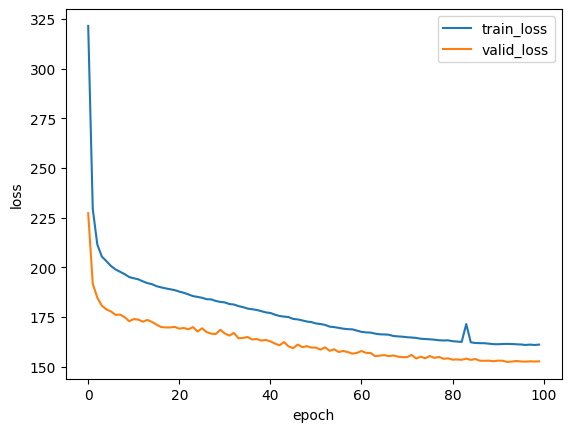

In [61]:
vega_stim, mean_weight, std_weight = run_vega_model("swa", PBMC_train_stim, PBMC_valid_stim, "stimulated", "activator.gmt", 1)

Epoch 0: train_loss=305.3614, valid_loss=224.4535
Epoch 10: train_loss=190.0442, valid_loss=171.9931
Epoch 20: train_loss=184.2231, valid_loss=168.2452
Epoch 30: train_loss=179.8186, valid_loss=164.6714
Epoch 40: train_loss=175.7636, valid_loss=161.9011
Epoch 50: train_loss=171.5810, valid_loss=160.5465
Epoch 60: train_loss=168.0300, valid_loss=157.5479
Epoch 70: train_loss=165.0433, valid_loss=155.4619
Epoch 80: train_loss=162.0981, valid_loss=153.2898
Epoch 90: train_loss=160.4755, valid_loss=152.1522


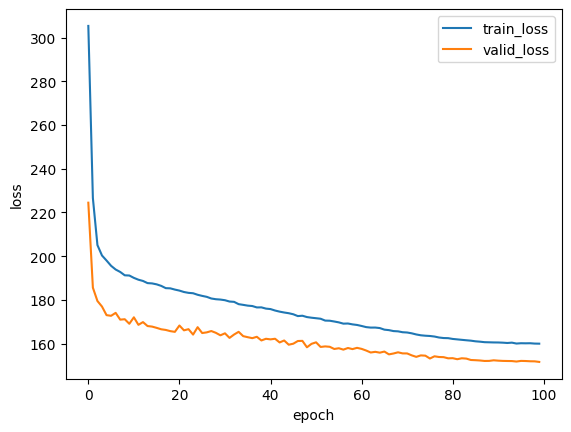

In [62]:
vega_stim, mean_weight, std_weight = run_vega_model("swa", PBMC_train_ctrl, PBMC_valid_ctrl, "control", "activator.gmt", 1)

epoch:  0  train_loss:  614.9555544385723   valid_loss:  521.9248798076923
epoch:  10  train_loss:  362.07140529856963   valid_loss:  306.0137117826022
epoch:  20  train_loss:  289.7446325713513   valid_loss:  247.85454618013821
epoch:  30  train_loss:  252.9368163464116   valid_loss:  219.72657717191257
epoch:  40  train_loss:  230.6751281887877   valid_loss:  203.50595151461087
epoch:  50  train_loss:  215.55964009902056   valid_loss:  192.9426492544321
epoch:  60  train_loss:  204.9933028127633   valid_loss:  186.09534219595102


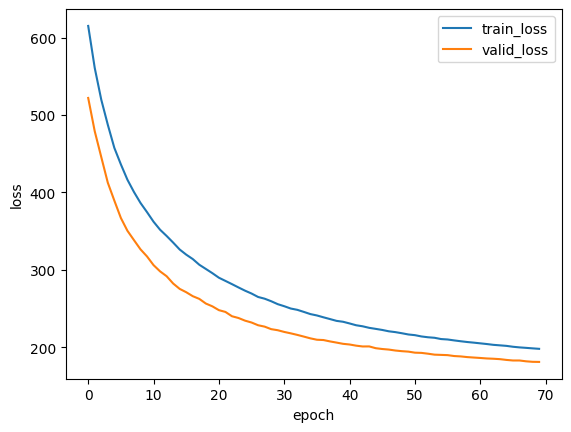

epoch:  0  train_loss:  614.70601309982   valid_loss:  525.1006610576923
epoch:  10  train_loss:  361.3159293380438   valid_loss:  309.15740262545074
epoch:  20  train_loss:  290.0865946003035   valid_loss:  248.74044799804688
epoch:  30  train_loss:  252.88008308410645   valid_loss:  219.66207064115085
epoch:  40  train_loss:  229.98570700252756   valid_loss:  202.96016340989334
epoch:  50  train_loss:  215.19740239311668   valid_loss:  193.4335162823017
epoch:  60  train_loss:  204.90088705923043   valid_loss:  187.0128150353065


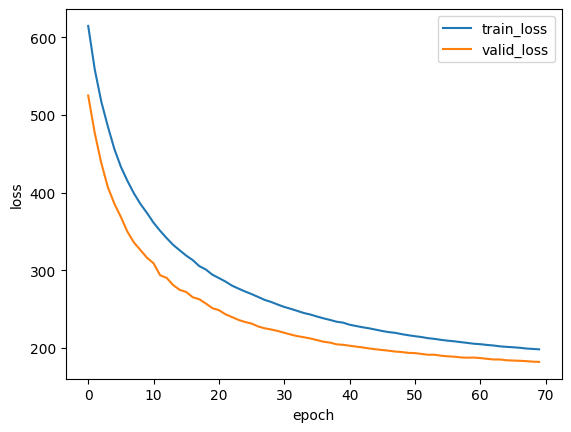

epoch:  0  train_loss:  614.4764610739315   valid_loss:  521.2152944711538
epoch:  10  train_loss:  362.85978010589   valid_loss:  305.8542715219351
epoch:  20  train_loss:  290.4932814205394   valid_loss:  250.2154787503756
epoch:  30  train_loss:  252.87597540313124   valid_loss:  219.03346017690805
epoch:  40  train_loss:  230.13442922105978   valid_loss:  203.52742943396936
epoch:  50  train_loss:  215.32047062294157   valid_loss:  193.0433067908654
epoch:  60  train_loss:  204.78801742254518   valid_loss:  186.687744140625


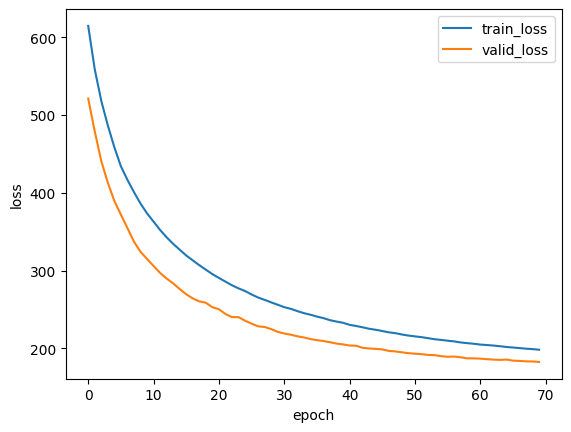

epoch:  0  train_loss:  614.4526875813802   valid_loss:  520.3484144944412
epoch:  10  train_loss:  361.4725404627183   valid_loss:  308.79451810396637
epoch:  20  train_loss:  289.4707583259134   valid_loss:  246.42794917179987
epoch:  30  train_loss:  252.86599701526117   valid_loss:  218.86301832932693
epoch:  40  train_loss:  230.25305587170172   valid_loss:  202.49095916748047
epoch:  50  train_loss:  215.27725156148276   valid_loss:  193.09497539813702
epoch:  60  train_loss:  204.51775404986213   valid_loss:  185.78054164006159


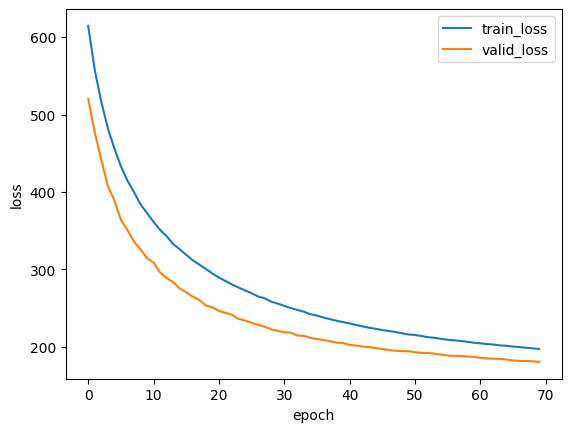

epoch:  0  train_loss:  612.9957173665365   valid_loss:  522.8979820838341
epoch:  10  train_loss:  359.9085186229033   valid_loss:  305.65950833834137
epoch:  20  train_loss:  289.7318432377834   valid_loss:  245.57654630220853
epoch:  30  train_loss:  252.81375316545075   valid_loss:  220.2451653113732
epoch:  40  train_loss:  230.0021655886781   valid_loss:  203.93600053053635
epoch:  50  train_loss:  215.15098220226812   valid_loss:  192.4979248046875
epoch:  60  train_loss:  204.4648017135321   valid_loss:  186.12097696157602


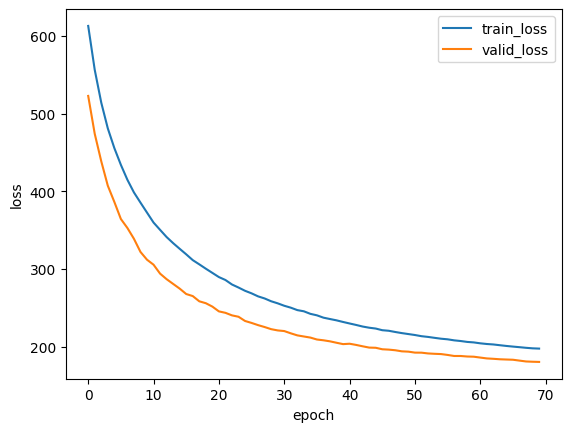

epoch:  0  train_loss:  614.5826197605508   valid_loss:  521.330322265625
epoch:  10  train_loss:  361.647284264658   valid_loss:  303.0867872971755
epoch:  20  train_loss:  289.99506692325366   valid_loss:  248.24901756873498
epoch:  30  train_loss:  252.7185493918026   valid_loss:  218.92052753155048
epoch:  40  train_loss:  230.0377259721943   valid_loss:  202.11932138296274
epoch:  50  train_loss:  215.0545907862046   valid_loss:  193.14552659254807
epoch:  60  train_loss:  204.6848393608542   valid_loss:  186.61052351731522


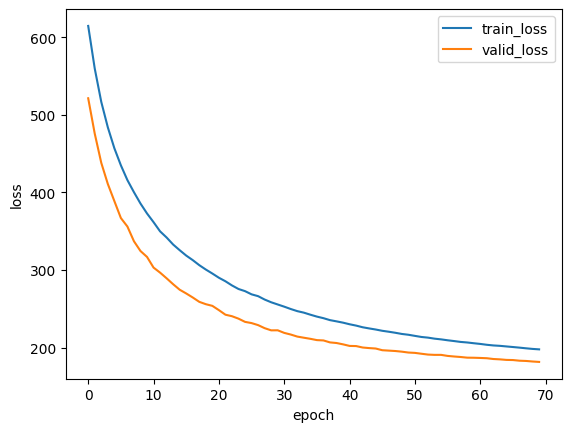

epoch:  0  train_loss:  616.6827748616537   valid_loss:  521.3904982346755
epoch:  10  train_loss:  361.94172488941865   valid_loss:  305.79305678147534
epoch:  20  train_loss:  290.3457457598518   valid_loss:  248.86355238694412
epoch:  30  train_loss:  253.17979524649826   valid_loss:  219.33915827824518
epoch:  40  train_loss:  230.19407291038362   valid_loss:  202.08238924466647
epoch:  50  train_loss:  215.05370656181785   valid_loss:  192.84861403245193
epoch:  60  train_loss:  204.6704631132238   valid_loss:  186.38936145489032


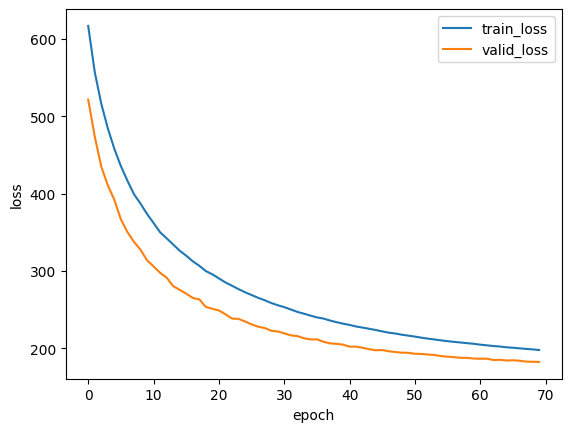

epoch:  0  train_loss:  614.2313761991613   valid_loss:  522.8321181077224
epoch:  10  train_loss:  362.24291543399585   valid_loss:  307.7338162935697
epoch:  20  train_loss:  289.04883410883883   valid_loss:  247.50071598933295
epoch:  30  train_loss:  252.69667251437318   valid_loss:  218.3330078125
epoch:  40  train_loss:  230.27813025081858   valid_loss:  202.96512779822717
epoch:  50  train_loss:  215.23415715086693   valid_loss:  192.97972341684195
epoch:  60  train_loss:  204.8226594363942   valid_loss:  186.15896665132962


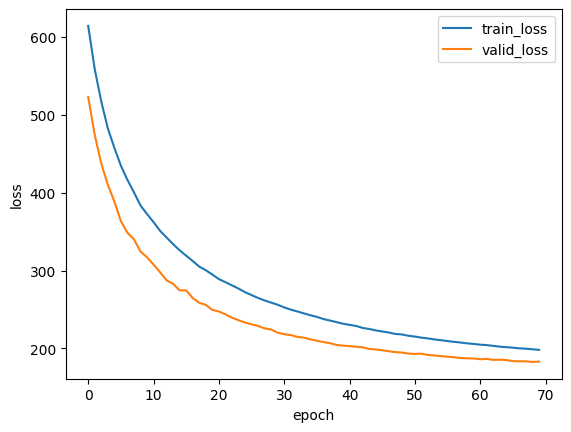

epoch:  0  train_loss:  613.2431945800781   valid_loss:  521.5620469313401
epoch:  10  train_loss:  361.28099224614164   valid_loss:  303.6045813927284
epoch:  20  train_loss:  290.03415964163986   valid_loss:  249.40120286207932
epoch:  30  train_loss:  253.01827905692306   valid_loss:  220.47169025127704
epoch:  40  train_loss:  230.0268694559733   valid_loss:  202.72477252666766
epoch:  50  train_loss:  214.8261604683072   valid_loss:  192.89898212139423
epoch:  60  train_loss:  204.37868948543772   valid_loss:  185.69386526254507


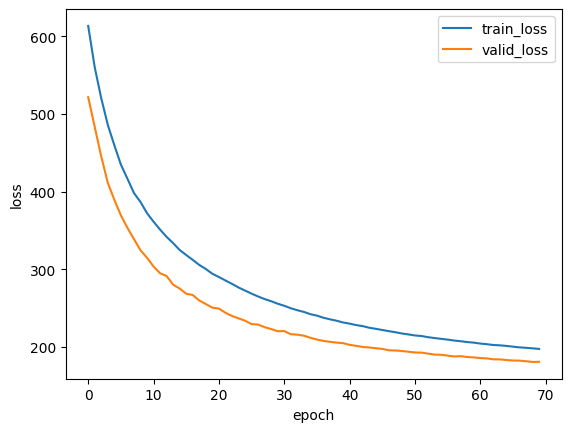

epoch:  0  train_loss:  613.3274251900467   valid_loss:  523.0148315429688
epoch:  10  train_loss:  361.63923465504365   valid_loss:  302.97423964280347
epoch:  20  train_loss:  290.37113122379077   valid_loss:  246.1100053053636
epoch:  30  train_loss:  253.3407153335272   valid_loss:  219.0692854661208
epoch:  40  train_loss:  230.6884105158787   valid_loss:  203.87502993070163
epoch:  50  train_loss:  215.56713238884421   valid_loss:  193.1014597966121
epoch:  60  train_loss:  204.97236992331113   valid_loss:  185.77061873215897


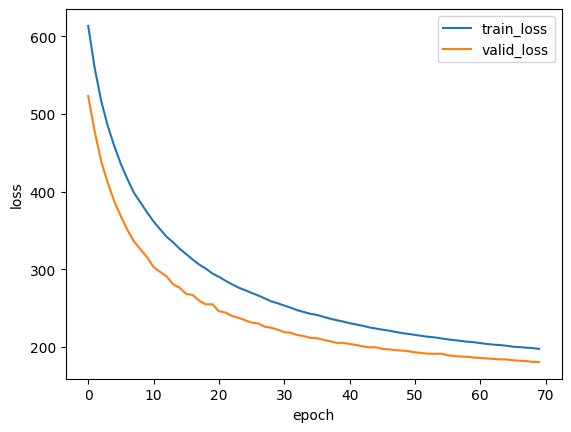

In [ ]:
vega_stim, mean_weight, std_weight = run_vega_model("bayes", PBMC_train_ctrl, PBMC_valid_ctrl, "control", "activator.gmt", 10)

epoch:  0  train_loss:  549.9449522835868   valid_loss:  468.4870082310268
epoch:  10  train_loss:  323.9998773847307   valid_loss:  273.33047158377514
epoch:  20  train_loss:  269.70555986676897   valid_loss:  233.02385820661272
epoch:  30  train_loss:  241.33512006487166   valid_loss:  211.87652587890625
epoch:  40  train_loss:  223.6379750115531   valid_loss:  199.8197283063616
epoch:  50  train_loss:  212.17099816458565   valid_loss:  192.81289563860213
epoch:  60  train_loss:  204.01481505802698   valid_loss:  187.98332868303572


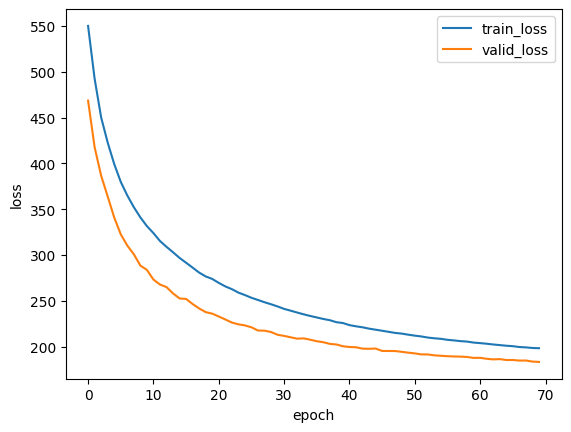

epoch:  0  train_loss:  547.8045943123954   valid_loss:  465.6189880371094
epoch:  10  train_loss:  320.8407892499651   valid_loss:  274.8512224469866
epoch:  20  train_loss:  268.64569664001465   valid_loss:  234.05349840436662
epoch:  30  train_loss:  241.65185710362024   valid_loss:  212.40812356131417
epoch:  40  train_loss:  223.3309328896659   valid_loss:  199.86192321777344
epoch:  50  train_loss:  211.60435226985388   valid_loss:  192.55784388950892
epoch:  60  train_loss:  203.55175767626082   valid_loss:  187.16963849748885


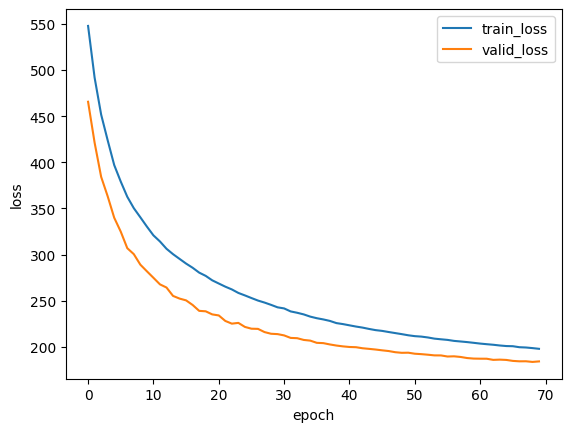

epoch:  0  train_loss:  549.0739288330078   valid_loss:  468.6991206577846
epoch:  10  train_loss:  320.95876393999373   valid_loss:  274.7980837140764
epoch:  20  train_loss:  268.7122941698347   valid_loss:  232.28970227922713
epoch:  30  train_loss:  240.76564843314034   valid_loss:  210.8587156023298
epoch:  40  train_loss:  223.47211170196533   valid_loss:  199.57015555245536
epoch:  50  train_loss:  211.61253588540214   valid_loss:  192.44163295200892
epoch:  60  train_loss:  203.54080963134766   valid_loss:  187.4665298461914


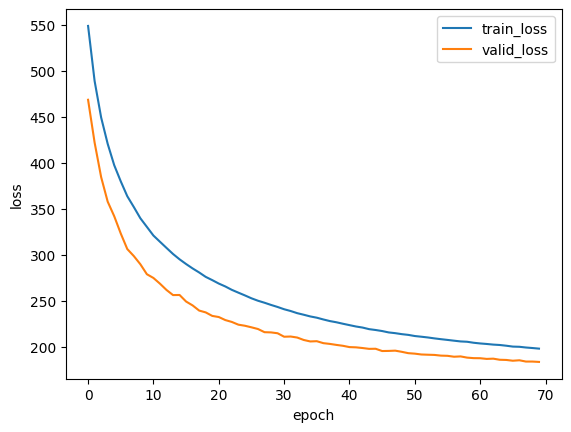

epoch:  0  train_loss:  551.116100856236   valid_loss:  469.9828316824777
epoch:  10  train_loss:  322.03842953273227   valid_loss:  273.8615057809012
epoch:  20  train_loss:  268.99945994785855   valid_loss:  232.49766758510046
epoch:  30  train_loss:  241.145503452846   valid_loss:  211.20823669433594
epoch:  40  train_loss:  223.44608334132604   valid_loss:  200.1065717424665
epoch:  50  train_loss:  212.20689392089844   valid_loss:  193.17600468226843
epoch:  60  train_loss:  203.64939321790422   valid_loss:  187.37152208600725


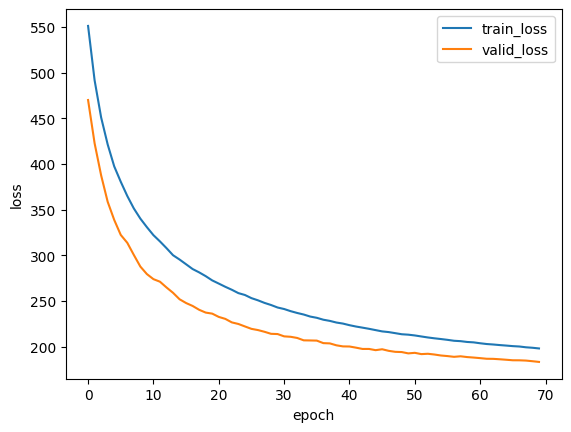

epoch:  0  train_loss:  545.7723742893764   valid_loss:  469.98147365025113
epoch:  10  train_loss:  321.19617434910367   valid_loss:  273.40866415841236
epoch:  20  train_loss:  268.4305512564523   valid_loss:  232.80735996791296
epoch:  30  train_loss:  241.0641234261649   valid_loss:  211.85341208321708
epoch:  40  train_loss:  223.41871901920862   valid_loss:  199.28287397112166
epoch:  50  train_loss:  211.891585622515   valid_loss:  192.53341020856584
epoch:  60  train_loss:  203.6098210471017   valid_loss:  187.98175266810827


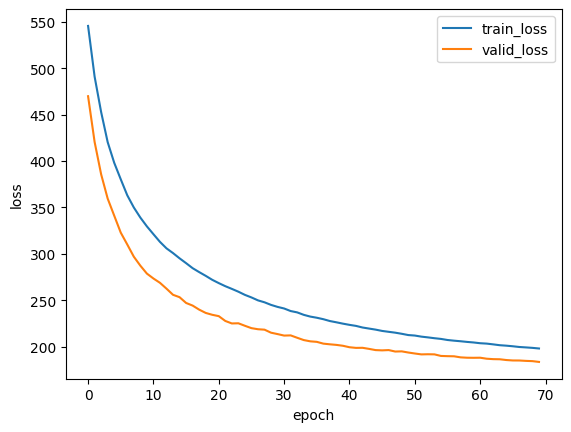

epoch:  0  train_loss:  547.2262273515973   valid_loss:  467.59063720703125
epoch:  10  train_loss:  320.97206115722656   valid_loss:  274.0788879394531
epoch:  20  train_loss:  268.8349050794329   valid_loss:  232.10708073207311
epoch:  30  train_loss:  240.34833635602678   valid_loss:  211.22692326137
epoch:  40  train_loss:  223.03557423182897   valid_loss:  199.52857099260603
epoch:  50  train_loss:  211.60569395337785   valid_loss:  192.19867706298828
epoch:  60  train_loss:  203.3756739752633   valid_loss:  187.52742876325334


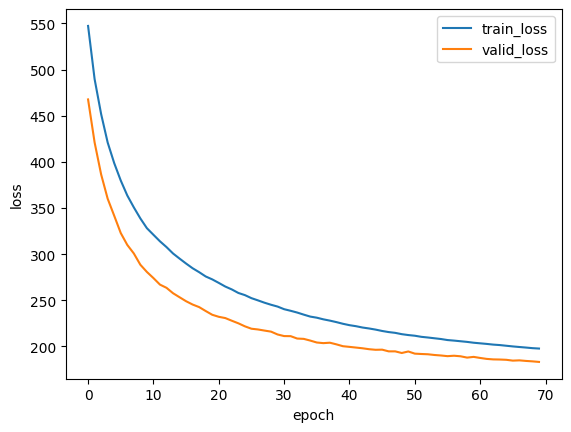

epoch:  0  train_loss:  549.6979359218052   valid_loss:  469.6692788260324
epoch:  10  train_loss:  322.98073714120045   valid_loss:  277.5480204990932
epoch:  20  train_loss:  269.08746583121166   valid_loss:  232.08782958984375
epoch:  30  train_loss:  241.29722349984306   valid_loss:  213.15955897739954
epoch:  40  train_loss:  223.83592755453927   valid_loss:  199.9230226789202
epoch:  50  train_loss:  212.31575679779053   valid_loss:  192.68975285121374
epoch:  60  train_loss:  203.73086983816964   valid_loss:  187.81055450439453


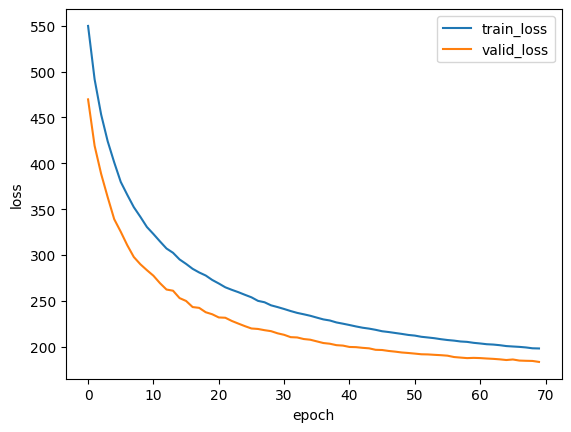

epoch:  0  train_loss:  548.3812779017857   valid_loss:  467.8757869175502
epoch:  10  train_loss:  322.1640488760812   valid_loss:  274.51954868861606
epoch:  20  train_loss:  268.69374929155623   valid_loss:  232.7727039882115
epoch:  30  train_loss:  241.22687639508928   valid_loss:  211.50105939592635
epoch:  40  train_loss:  223.4479510443551   valid_loss:  201.0549806867327
epoch:  50  train_loss:  211.65771307264055   valid_loss:  192.1962116786412
epoch:  60  train_loss:  203.6899597985404   valid_loss:  187.4308308192662


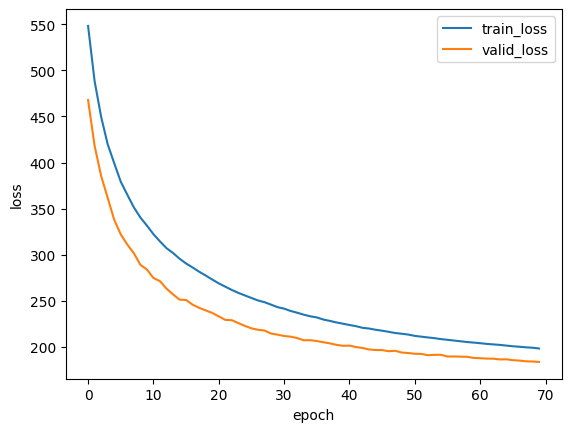

epoch:  0  train_loss:  549.8366791861398   valid_loss:  469.64750017438615
epoch:  10  train_loss:  322.5108127593994   valid_loss:  274.8837116786412
epoch:  20  train_loss:  269.2881524222238   valid_loss:  231.66964067731584
epoch:  30  train_loss:  241.77141625540597   valid_loss:  211.73416791643416
epoch:  40  train_loss:  224.23044885907854   valid_loss:  201.17527444022042
epoch:  50  train_loss:  212.63975988115584   valid_loss:  193.41610172816686
epoch:  60  train_loss:  203.96433544158936   valid_loss:  187.353519984654


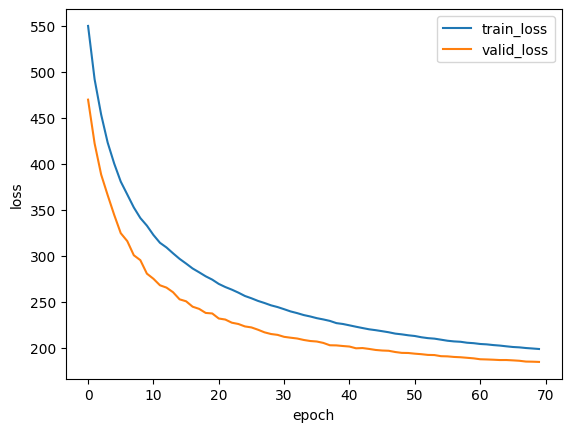

epoch:  0  train_loss:  547.6064137050083   valid_loss:  463.38049970354353
epoch:  10  train_loss:  322.57000514439176   valid_loss:  280.0009569440569
epoch:  20  train_loss:  269.2957458496094   valid_loss:  231.43955666678292
epoch:  30  train_loss:  240.5257170540946   valid_loss:  212.79811641148157
epoch:  40  train_loss:  223.5284767150879   valid_loss:  199.9159218924386
epoch:  50  train_loss:  211.58715425218855   valid_loss:  192.68086133684432
epoch:  60  train_loss:  203.53714547838484   valid_loss:  187.15558188302177


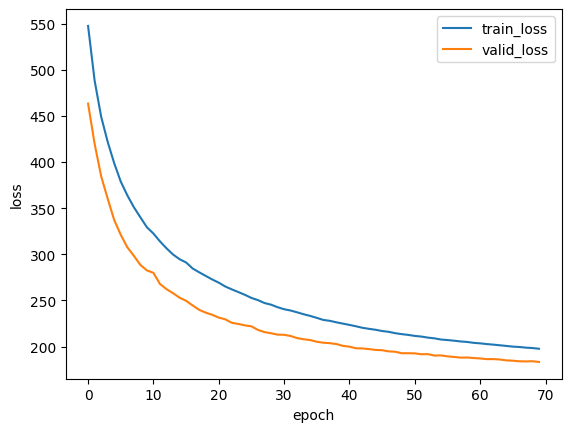

In [26]:
vega_stim, mean_weight, std_weight = run_vega_model("bayes", PBMC_train_stim, PBMC_valid_stim, "stimulated", "STAT_activator.gmt", 10)

epoch:  0  train_loss:  518.3033435297947   valid_loss:  440.0823845496544
epoch:  10  train_loss:  320.9407044952991   valid_loss:  272.0024813138522
epoch:  20  train_loss:  268.1425329470167   valid_loss:  232.18867668738733
epoch:  30  train_loss:  239.4521079717898   valid_loss:  210.13206892747147
epoch:  40  train_loss:  221.54416751861572   valid_loss:  197.58805260291467
epoch:  50  train_loss:  209.03345753164854   valid_loss:  188.7732414832482
epoch:  60  train_loss:  200.1434964759677   valid_loss:  183.33241037222055


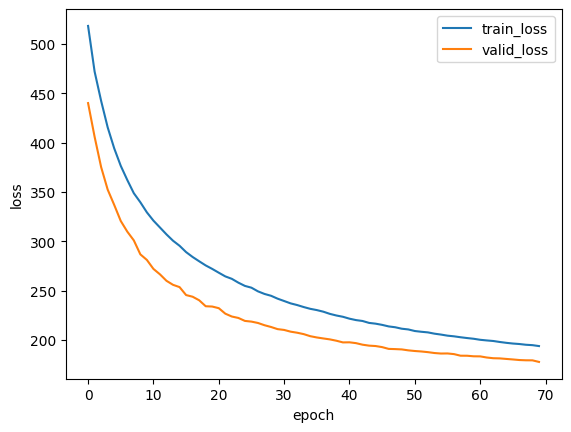

epoch:  0  train_loss:  520.2830650479186   valid_loss:  438.3075420673077
epoch:  10  train_loss:  321.1543840146532   valid_loss:  274.9839782714844
epoch:  20  train_loss:  268.6309409796023   valid_loss:  229.78360220102164
epoch:  30  train_loss:  240.23502865959617   valid_loss:  209.0656744150015
epoch:  40  train_loss:  221.7498280207316   valid_loss:  197.50877321683444
epoch:  50  train_loss:  209.02170123305976   valid_loss:  188.82374396690955
epoch:  60  train_loss:  200.40194447835287   valid_loss:  182.77361708420975


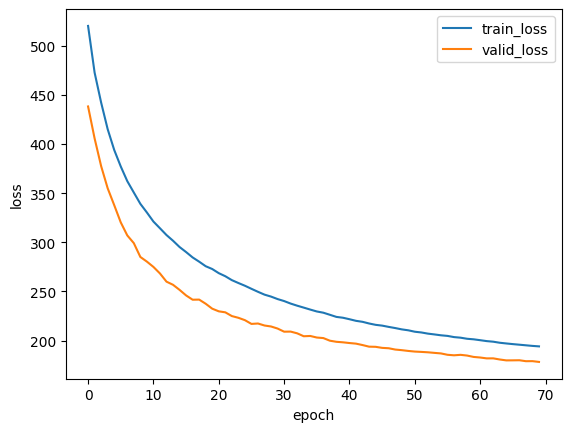

epoch:  0  train_loss:  516.3719434551164   valid_loss:  438.79219407301684
epoch:  10  train_loss:  321.70546198826213   valid_loss:  272.71071096567005
epoch:  20  train_loss:  268.17686761594285   valid_loss:  230.11697270320013
epoch:  30  train_loss:  239.46768951416016   valid_loss:  210.33552962083084
epoch:  40  train_loss:  221.53811226639093   valid_loss:  196.63348623422476
epoch:  50  train_loss:  208.8155609953637   valid_loss:  188.24152022141678
epoch:  60  train_loss:  199.98655943777047   valid_loss:  181.72816349909857


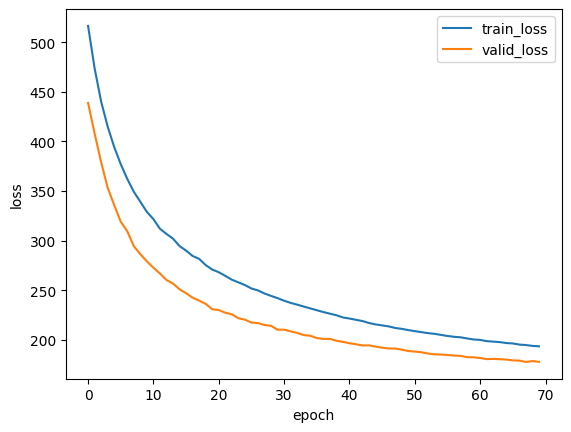

epoch:  0  train_loss:  517.1605836456897   valid_loss:  440.42093482384314
epoch:  10  train_loss:  321.7977594113817   valid_loss:  275.40215360201324
epoch:  20  train_loss:  268.0130630567962   valid_loss:  230.38949232835037
epoch:  30  train_loss:  239.6031680387609   valid_loss:  209.4335943368765
epoch:  40  train_loss:  221.13563328163298   valid_loss:  197.588868361253
epoch:  50  train_loss:  209.14938429290174   valid_loss:  188.71072915884164
epoch:  60  train_loss:  200.25571839949663   valid_loss:  182.82411252535306


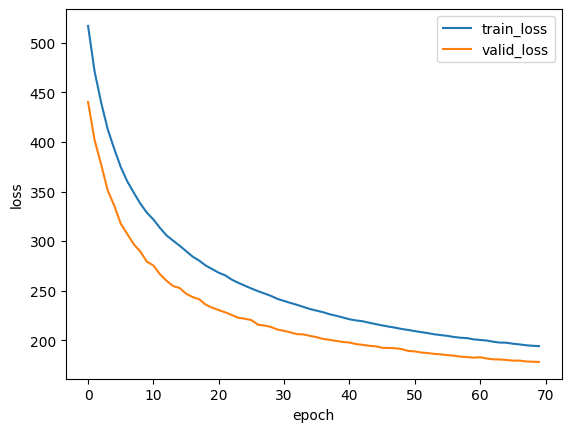

epoch:  0  train_loss:  517.6146855073816   valid_loss:  440.69007756159857
epoch:  10  train_loss:  321.44641861261107   valid_loss:  272.65266183706433
epoch:  20  train_loss:  268.5414608974083   valid_loss:  231.0912146935096
epoch:  30  train_loss:  240.04660168816062   valid_loss:  209.56306868333084
epoch:  40  train_loss:  221.82106186361875   valid_loss:  196.2138390174279
epoch:  50  train_loss:  209.4787977069032   valid_loss:  188.7510211651142
epoch:  60  train_loss:  199.8085614746692   valid_loss:  181.7508803147536


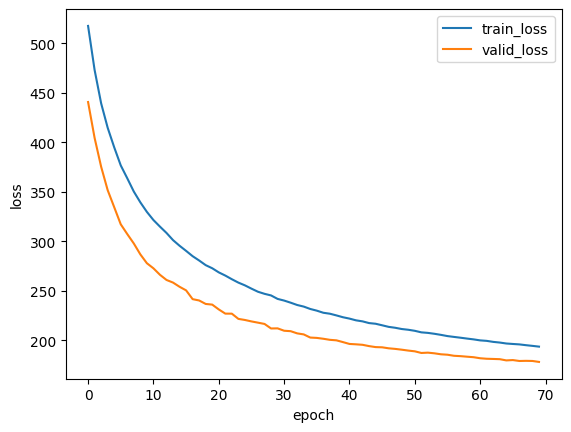

epoch:  0  train_loss:  519.5960942436667   valid_loss:  441.29940913273737
epoch:  10  train_loss:  322.4194892060523   valid_loss:  276.70511333759015
epoch:  20  train_loss:  268.5643444435269   valid_loss:  232.35521874060998
epoch:  30  train_loss:  240.71959992951037   valid_loss:  209.66189927321213
epoch:  40  train_loss:  221.7031747780594   valid_loss:  196.51798541729266
epoch:  50  train_loss:  209.6249137205236   valid_loss:  189.81439326359674
epoch:  60  train_loss:  200.29657543406768   valid_loss:  182.41554788442758


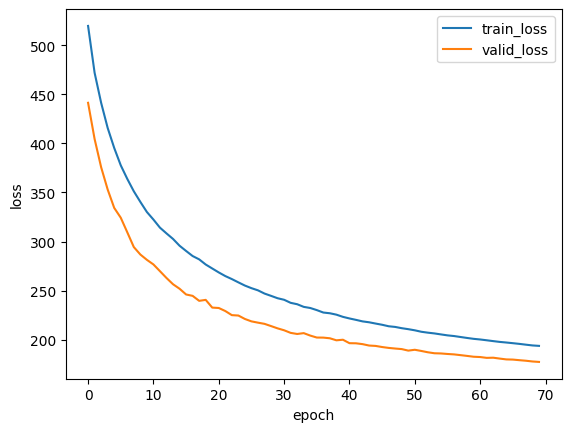

epoch:  0  train_loss:  517.889694887049   valid_loss:  437.7222888653095
epoch:  10  train_loss:  320.1774750503839   valid_loss:  271.84015127328723
epoch:  20  train_loss:  267.72800527834426   valid_loss:  230.18353682297928
epoch:  30  train_loss:  239.79609870910645   valid_loss:  209.0400361281175
epoch:  40  train_loss:  221.80379224291036   valid_loss:  196.60622171255258
epoch:  50  train_loss:  209.04964796702066   valid_loss:  189.00473961463342
epoch:  60  train_loss:  199.7365135866053   valid_loss:  181.79557565542368


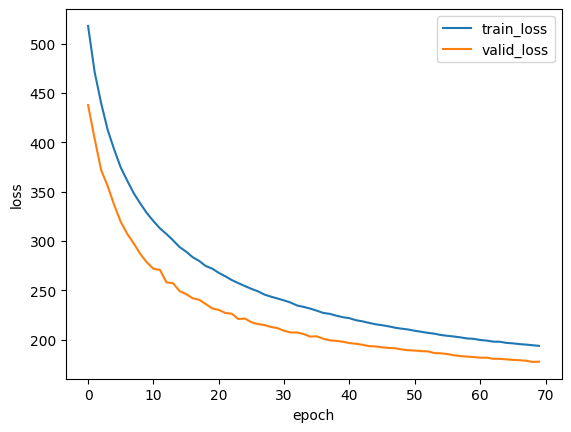

epoch:  0  train_loss:  516.3031586291743   valid_loss:  439.37195645845856
epoch:  10  train_loss:  321.335922016817   valid_loss:  274.38447336050183
epoch:  20  train_loss:  267.7518886491364   valid_loss:  231.7879838209886
epoch:  30  train_loss:  240.01660442352295   valid_loss:  208.56520139254056
epoch:  40  train_loss:  222.02344928068274   valid_loss:  198.10389298659103
epoch:  50  train_loss:  208.988504521987   valid_loss:  189.2937985933744
epoch:  60  train_loss:  200.15387697780832   valid_loss:  182.11937185434195


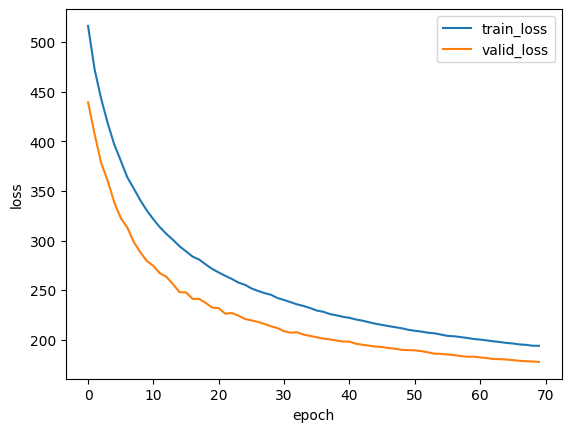

epoch:  0  train_loss:  517.5782368977865   valid_loss:  439.5149888258714
epoch:  10  train_loss:  321.41766147987516   valid_loss:  272.76151099571814
epoch:  20  train_loss:  268.60698281082455   valid_loss:  231.2124504676232
epoch:  30  train_loss:  239.8196850196988   valid_loss:  209.2515352689303
epoch:  40  train_loss:  221.83807410445868   valid_loss:  196.68358905498798
epoch:  50  train_loss:  209.13363363228592   valid_loss:  188.7720724252554
epoch:  60  train_loss:  199.8310925352807   valid_loss:  182.24329552283655


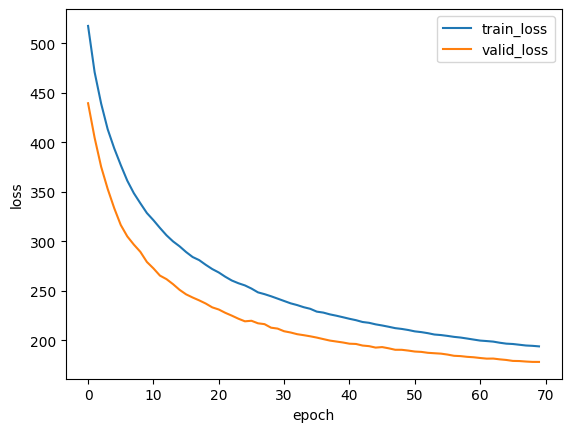

epoch:  0  train_loss:  517.6094783708161   valid_loss:  438.7811408409706
epoch:  10  train_loss:  320.2019517187979   valid_loss:  273.7732144869291
epoch:  20  train_loss:  267.37598725861193   valid_loss:  229.52169330303485
epoch:  30  train_loss:  239.27511559280694   valid_loss:  209.38923527644232
epoch:  40  train_loss:  221.85221529941933   valid_loss:  196.63106712928186
epoch:  50  train_loss:  209.22692858004103   valid_loss:  188.09013014573318
epoch:  60  train_loss:  199.83811842226515   valid_loss:  182.14126293475812


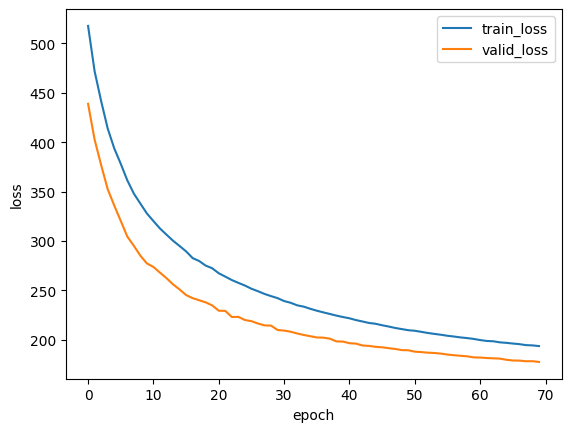

In [24]:
vega_stim, mean_weight, std_weight = run_vega_model("bayes", PBMC_train_ctrl, PBMC_valid_ctrl, "control", "STAT_activator.gmt", 10)

# Plotting function

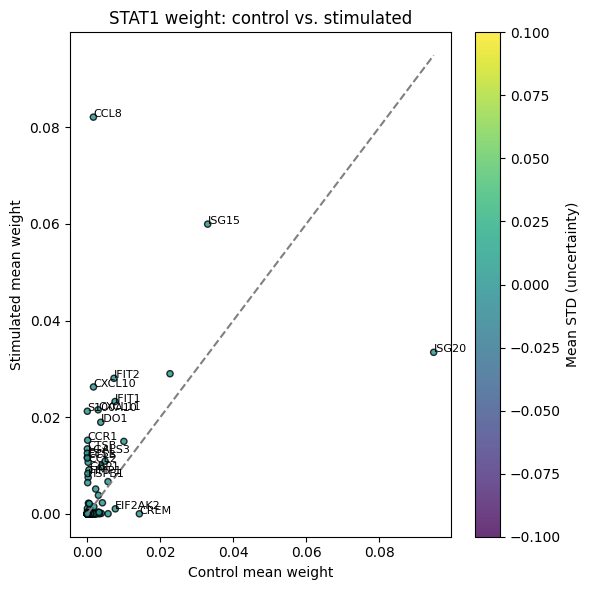

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## CHANGE these values to generate different plots
TF = "STAT1"
TF_type = "activator"
model = "swa"

# 1) Load means (you already have these)
mean_weight_stim = pd.read_csv(f"stimulated_{TF_type}_{model}_weight_mean.csv", index_col=0)
mean_weight_ctrl = pd.read_csv(f"control_{TF_type}_{model}_weight_mean.csv", index_col=0)

stim = mean_weight_stim[TF].rename("stim")
ctrl = mean_weight_ctrl[TF].rename("ctrl")

# 2) Load the std‐weight CSVs in exactly the same shape
std_weight_stim  = pd.read_csv(f"stimulated_{TF_type}_{model}_weight_std.csv", index_col=0)
std_weight_ctrl  = pd.read_csv(f"control_{TF_type}_{model}_weight_std.csv",  index_col=0)

std_stim = std_weight_stim[TF].rename("std_stim")
std_ctrl = std_weight_ctrl[TF].rename("std_ctrl")

# 3) Merge everything on the gene index, dropping any missing
merged = pd.concat([ctrl, stim, std_ctrl, std_stim], axis=1).dropna()

# 4) Compute a single uncertainty score per point
#    Here we take the mean of the two std’s, but you could also use max(), sum(), etc.
merged["uncertainty"] = merged[["std_ctrl","std_stim"]].mean(axis=1)

# 5) Scatter with color = uncertainty
plt.figure(figsize=(6,6))
sc = plt.scatter(merged["ctrl"], merged["stim"],
                 c=merged["uncertainty"],
                 cmap="viridis",
                 s=20,             # marker size
                 edgecolor="k",    # thin black outline
                 alpha=0.8)

# 6) Diagonal & axes
plt.plot([merged["ctrl"].min(), merged["ctrl"].max()],
         [merged["ctrl"].min(), merged["ctrl"].max()],
         color='grey', linestyle='--')
plt.xlabel("Control mean weight")
plt.ylabel("Stimulated mean weight")
plt.title(f"{TF} weight: control vs. stimulated")

# 7) Colorbar
cbar = plt.colorbar(sc, label="Mean STD (uncertainty)")

# 8) Optional: annotate outliers as before
merged["dist"] = np.abs(merged["stim"] - merged["ctrl"]) / np.sqrt(2)
top = merged.nlargest(20, "dist")
for gene, row in top.iterrows():
    plt.annotate(gene, (row["ctrl"], row["stim"]), fontsize=8)

plt.tight_layout()
plt.show()